# Задание 1: сгенерировать датасет.

Вам предстоит обучить микро-GPT2 модель для генерации текста. Но для начала вам
нужно сделать датасет!
Датасет должен состоять из текстов вашего любого писателя. Требование к датасету:

*   Датасет должен быть одним txt-файлом.
*   Выложите датасет куда-нибудь в открытый доступ и загрузите в этот ноутбук с помощью wget
*   Датасет должен содержать по меньшей мере 500 тысяч символов. Лучше -- миллион.


Советы:
* www.lib.ru -- удобный сайт с txt текстов русских писателей.
* Моделировать поэзию чуть веселее, чем прозу.

# Задание 2: оптимизировать модель
Ниже приведен код обучения микро-GPT2. Прежде, чем обучать, нужно немного оптимизировать код.  Объедините `Head` и `MultiHeadAttention` в один класс, который обрабатывает все головы параллельно, рассматривая головы как еще одну размерность. Это поможет избавиться от цикла в `MultiHeadAttention` и ускорить процесс обучения. Проверьте, что ваша имплементация идентична той, что приведена ниже.
# Задание 3: обучите модель на ваших текстах
Используйте те параметры, которые указаны ниже и обучите модель на вашем датасете. Обучение в колабе может занять около часа. Если результаты будут выглядеть неубедительно, учите подольше. Если есть доступ к хорошей GPU, можете немного увеличить размер трансформера.
# Задание 4: сложение
Обучите GPT выполнять сложение двух чисел, то есть $a+b=c$. Возможно, вам будет полезно предсказать цифры числа $c$ в обратном порядке, поскольку типичный алгоритм сложения (который, как мы надеемся, GPT выучит) выполняется справа налево. Возможно, вы захотите модифицировать dataloader, чтобы он просто предоставлял случайные задачи и пропускал генерацию train и val. Возможно, вы захотите замаскировать loss на входных позициях a+b, которые просто определяют задачу, используя y=-1 в таргетах (см. CrossEntropyLoss ignore_index). Работает ли сложение? Постройте график точности сложения в зависимости от количества цифр в примере. Для этого сгенерируйте по 100 примеров с 2-мя цифрам, 3-мя и т.д.
# Задание 5: калькулятор
Если ваш трасформер научился складывать (хотя бы до какого-то порядка), научите его умножать, делить и вычитать. Попробуйте обучить простой калькулятор (без скобок), в котором по одному разу может встречать каждый из знаков: *, /, +, -. Это не очень простая задача :) Возможно, вы захотите добавить в датасет chain of thoughts (https://arxiv.org/abs/2201.11903), а не только ответ.



# Генерация стихов

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [3]:
# # hyperparameters
# batch_size = 64
# block_size = 256
# max_iters = 5000
# eval_interval = 500
# learning_rate = 3e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 384
# n_head = 6 # D = 384 // 6
# n_layer = 6
# dropout = 0.2
# # ------------

# torch.manual_seed(1337)

# hyperparameters
batch_size = 512
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 1600
n_head = 12 # D = 384 // 6
n_layer = 48
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [9]:
!wget https://raw.githubusercontent.com/marulyanova/NLP_6sem/main/dataset_poetry_mac.txt

--2024-05-29 09:44:58--  https://raw.githubusercontent.com/marulyanova/NLP_6sem/main/dataset_poetry_mac.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 677788 (662K) [text/plain]
Сохранение в: «dataset_poetry_mac.txt»

dataset_poetry_mac. 100%[===================>] 661,90K  1,64MB/s    за 0,4s    

2024-05-29 09:44:59 (1,64 MB/s) - «dataset_poetry_mac.txt» сохранён [677788/677788]



In [12]:
import re

with open('dataset_poetry_mac.txt', 'r', encoding = 'MACCYRILLIC') as file:
    lines = file.readlines()

new_lines = []
for line in lines:

    # убрать пробелы в начале строки, оставить только русские буквы, убрать строки, где только цифры (года написания стихов), названия стихов

    line = line.lstrip()
    line = re.sub(r'[a-zA-Z]', '', line)
    if line.isdigit():
        continue
    if line.isupper():
            line = '*\n'
    new_lines.append(line)

with open('dataset_poetry_mac_modified.txt', 'w', encoding = 'MACCYRILLIC') as file:
    file.writelines(new_lines)


with open('dataset_poetry_mac_modified.txt', 'r', encoding = 'MACCYRILLIC') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [13]:
text[:600].split('\n')

['Ты опять упрекнула меня,',
 'Что я с музой моей раздружился,',
 'Что заботам текущего дня',
 'И забавам его подчинился.',
 'Для житейских расчетов и чар',
 'Не расстался б я с музой моею,',
 'Но бог весть, не погас ли тот дар,',
 'Что, бывало, дружил меня с нею?',
 'Но не брат еще людям поэт,',
 'И тернист его путь, и непрочен,',
 'Я умел не бояться клевет,',
 'Не был ими я сам озабочен;',
 'Но я знал, чье во мраке ночном',
 'Надрывалося сердце с печали',
 'И на чью они грудь упадали свинцом,',
 'И кому они жизнь отравляли.',
 'И пускай они мимо прошли,',
 'Надо мною ходившие грозы,',
 'Знаю я, чьи молитвы и слезы',
 'Роковую стрелу отвели...',
 'Да и время ушло,- я устал']

In [14]:
len(text) # длина датасета 600к символов

626213

In [15]:
stoi

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 '(': 5,
 ')': 6,
 '*': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '0': 11,
 '1': 12,
 '2': 13,
 '3': 14,
 '4': 15,
 '5': 16,
 '6': 17,
 '7': 18,
 '8': 19,
 '9': 20,
 ':': 21,
 ';': 22,
 '<': 23,
 '>': 24,
 '?': 25,
 '@': 26,
 '[': 27,
 ']': 28,
 '_': 29,
 '{': 30,
 '}': 31,
 'А': 32,
 'Б': 33,
 'В': 34,
 'Г': 35,
 'Д': 36,
 'Е': 37,
 'Ж': 38,
 'З': 39,
 'И': 40,
 'Й': 41,
 'К': 42,
 'Л': 43,
 'М': 44,
 'Н': 45,
 'О': 46,
 'П': 47,
 'Р': 48,
 'С': 49,
 'Т': 50,
 'У': 51,
 'Ф': 52,
 'Х': 53,
 'Ц': 54,
 'Ч': 55,
 'Ш': 56,
 'Щ': 57,
 'Ъ': 58,
 'Ы': 59,
 'Ь': 60,
 'Э': 61,
 'Ю': 62,
 'Я': 63,
 'а': 64,
 'б': 65,
 'в': 66,
 'г': 67,
 'д': 68,
 'е': 69,
 'ж': 70,
 'з': 71,
 'и': 72,
 'й': 73,
 'к': 74,
 'л': 75,
 'м': 76,
 'н': 77,
 'о': 78,
 'п': 79,
 'р': 80,
 'с': 81,
 'т': 82,
 'у': 83,
 'ф': 84,
 'х': 85,
 'ц': 86,
 'ч': 87,
 'ш': 88,
 'щ': 89,
 'ъ': 90,
 'ы': 91,
 'ь': 92,
 'э': 93,
 'ю': 94,
 'я': 95,
 'ё': 96}

In [16]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [17]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [18]:
class MultiHeadAttention_Parallel(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.query = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.value = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.head_size = head_size

        self.proj = nn.Linear(head_size * num_heads, n_embd)

    def forward(self, x):
        # input of size (B, T, C)
        # output of size (B, T, D * num_heads)

        B, T, C = x.shape
        k = self.key(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        q = self.query(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        v = self.value(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)

        masks = self.tril[:T, :T].unsqueeze(0).unsqueeze(0)
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim =- 1)
        wei = self.dropout(wei)
        out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, self.head_size * self.num_heads)
        out = self.dropout(self.proj(out))

        return out

In [19]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [20]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_Parallel(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [21]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [23]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

1474.822497 M parameters


In [ ]:
try:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  for iter in range(max_iters):

      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss()
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

      xb, yb = get_batch('train')
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

except KeyboardInterrupt: 0

step 0: train loss 4.6937, val loss 4.7020
step 500: train loss 2.3368, val loss 2.4008
step 1000: train loss 1.8596, val loss 2.0421
step 1500: train loss 1.5944, val loss 1.9295
step 2000: train loss 1.4269, val loss 1.9088
step 2500: train loss 1.2806, val loss 1.9353
step 3000: train loss 1.1455, val loss 1.9942
step 3500: train loss 1.0095, val loss 2.0591
step 4000: train loss 0.8757, val loss 2.1618
step 4500: train loss 0.7514, val loss 2.2879
step 4999: train loss 0.6358, val loss 2.3948


## Результаты генерации

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens = 500)[0].tolist()))


Влад у небес, мать Боюся, хоть и вдохновенных,
Не сели одинких гор
Заковарным в ином племенье дань
За кустером, улетела, молчалая
И спящей в беседе ядов шинки
И средь них гордела невежен;
Играть сопутного Россиянки -
Кричит на тихом в капичке.
И, моя лил твой был крыток,
Скажи, даже слышу в лед,
Воспросами до творца кручи,
И ярый и жених думает обнимает.
Питомец мудрец был у обним,
Кроме сколько в зеркалье сметливой,
Держа пал сухуду прожает,
На ветвями тверых законел.
Однажды утомлен, везде пос


In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens = 500)[0].tolist()))


И звезда горда потерянь!
Но не закрылся мне, роскоши судь
Спокойной рукою спиной!
Мною на радостью в немиле, -
Мною старальной для страстью овладеленный.
Он был влюблен от ранний серы ус,
И все, для клякою нанесенный,
И как божий остынет пыла ть и лечу.
*
Когда зареют волнует ковровь -
Уже зарею пусть вам обиды,
Сна гром колпака и заснает.
Он вас не увидит штуненья;
Волнуясь ночи потомству находит
Не вдруг за кричи ночный темнотой,
Ужели тлполеды кровавой?
Все тихо, видит он молчат.
Пред сомным,


----

# Сложение

In [ ]:
import pandas as pd
import numpy as np
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### Создание датасета
Если имеем пример 'abc+xyz=nmk', то для задачи предсказывания следующего токена, в датасете создадим четыре записи:

1) context 'abc+xyz=' target 'abc+xyz=k'

2) context 'abc+xyz=k' target 'abc+xyz=km'

3) context 'abc+xyz=km' target 'abc+xyz=kmn'

4) context 'abc+xyz=kmn' target 'abc+xyz=kmnE' (E - end of sequence)

Более короткий пример '1+1=2':

1) context '1+1=' target '1+1=2'

1) context '1+1=2' target '1+1=2E'

Максимальная длина последовательности = 12, так как max = трехзначное + трехзначное = трехзначноеЕ

Таргет (результат сложения) перевёрнут.

Паддинги для дополнения до максимальной длины добавляем вперёд последовательности (примера)

In [ ]:
def add_padding(context, max_len, pad_token = '.'):
    return pad_token * (max_len - len(context)) + context

NUM_SAMPLES = 100000
context, target = [], []

def create_sample(x, y):
  global context
  global target

  a, b = random.randint(x, y), random.randint(x, y)
  if a + b >= 1000:
    return
  task = str(a) + '+' + str(b) + '='
  ans = str(a + b)[::-1]
  for i in range(len(ans)):
    context += [add_padding(task + ans[:i], 12)]
    target += [add_padding(task + ans[: i + 1], 12)]
  context += [add_padding(task + ans, 12)]
  target += [add_padding(task + ans + 'E', 12)]

for i in range(NUM_SAMPLES):
  create_sample(0, 10)
  create_sample(10, 100)
  create_sample(100, 1000)

dataset = pd.DataFrame({'context': context, 'target': target}).drop_duplicates()
dataset

,context,target
0,........7+5=,.......7+5=2
1,.......7+5=2,......7+5=21
2,......7+5=21,.....7+5=21E
3,......25+53=,.....25+53=8
4,.....25+53=8,....25+53=87
...,...,...
773492,.298+502=008,298+502=008E
773505,....280+417=,...280+417=7
773506,...280+417=7,..280+417=79
773507,..280+417=79,.280+417=796


In [ ]:
chars = ['.'] + [str(i) for i in range(0, 10)] + ['+', '=', 'E']
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [ ]:
stoi

{'.': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 '+': 11,
 '=': 12,
 'E': 13}

In [ ]:
dataset['context_encoded'] = dataset['context'].apply(lambda x: [stoi[i] for i in x])
dataset['target_encoded'] = dataset['target'].apply(lambda x: [stoi[i] for i in x])
dataset

,context,target,context_encoded,target_encoded
0,........7+5=,.......7+5=2,"[0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 6, 12]","[0, 0, 0, 0, 0, 0, 0, 8, 11, 6, 12, 3]"
1,.......7+5=2,......7+5=21,"[0, 0, 0, 0, 0, 0, 0, 8, 11, 6, 12, 3]","[0, 0, 0, 0, 0, 0, 8, 11, 6, 12, 3, 2]"
2,......7+5=21,.....7+5=21E,"[0, 0, 0, 0, 0, 0, 8, 11, 6, 12, 3, 2]","[0, 0, 0, 0, 0, 8, 11, 6, 12, 3, 2, 13]"
3,......25+53=,.....25+53=8,"[0, 0, 0, 0, 0, 0, 3, 6, 11, 6, 4, 12]","[0, 0, 0, 0, 0, 3, 6, 11, 6, 4, 12, 9]"
4,.....25+53=8,....25+53=87,"[0, 0, 0, 0, 0, 3, 6, 11, 6, 4, 12, 9]","[0, 0, 0, 0, 3, 6, 11, 6, 4, 12, 9, 8]"
...,...,...,...,...
773492,.298+502=008,298+502=008E,"[0, 3, 10, 9, 11, 6, 1, 3, 12, 1, 1, 9]","[3, 10, 9, 11, 6, 1, 3, 12, 1, 1, 9, 13]"
773505,....280+417=,...280+417=7,"[0, 0, 0, 0, 3, 9, 1, 11, 5, 2, 8, 12]","[0, 0, 0, 3, 9, 1, 11, 5, 2, 8, 12, 8]"
773506,...280+417=7,..280+417=79,"[0, 0, 0, 3, 9, 1, 11, 5, 2, 8, 12, 8]","[0, 0, 3, 9, 1, 11, 5, 2, 8, 12, 8, 10]"
773507,..280+417=79,.280+417=796,"[0, 0, 3, 9, 1, 11, 5, 2, 8, 12, 8, 10]","[0, 3, 9, 1, 11, 5, 2, 8, 12, 8, 10, 7]"


In [ ]:
train_dataset = TensorDataset(torch.tensor(np.stack(dataset['context_encoded'].values)[:int(len(dataset) * 0.8)]),
                              torch.tensor(np.stack(dataset['target_encoded'].values)[:int(len(dataset) * 0.8)]))

val_dataset = TensorDataset(torch.tensor(np.stack(dataset['context_encoded'].values)[int(len(dataset) * 0.8):]),
                            torch.tensor(np.stack(dataset['target_encoded'].values)[int(len(dataset) * 0.8):]))

In [ ]:
# hyperparameters
batch_size = 64
block_size = 12
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6 # D = 384 // 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [ ]:
model = GPTLanguageModel().to(device)
m = model.to(device)

In [ ]:
try:
  optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

  for iter in range(max_iters):

      train_loss, val_loss = 0, 0

      ''' Если прогонять каждую эпоху весь датасет, это будет очень долго.
       Поэтому в каждой эпохе шаффлю лоадер (чтобы модель видела разные данные) и беру первые 50 батчей на обучение и вторые 50 на валидацию.'''
      batches = 0
      train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
      val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

      for context, target in train_loader:

          context, target = context.to(device), target.to(device)
          logits, _ = model(context)

          B, T, C = logits.shape
          logits = logits.view(B * T, C)

          '''Нам не нужно в таргете предсказывать сам пример, то есть всё перед знаком = включительно.
           Создадим маску, которая будет занулять (а 0 в stoi это точка-паддинг) лишнюю часть и в кросс-энтропии будем игнорировать этот паддинг'''
          mask = torch.zeros_like(target, dtype = torch.bool, device=device)
          for i in range(target.size(0)):
            index_eq = ((target[i] == 12).int()).nonzero(as_tuple=True)[0] # stoi['='] = 12
            mask[i, :index_eq + 1] = True
            masked_targets = target.masked_fill(mask, 0)
            masked_targets = masked_targets.view(B * T)

            loss = F.cross_entropy(logits, masked_targets, ignore_index = 0)

          train_loss += loss

          optimizer.zero_grad(set_to_none = True)
          loss.backward()
          optimizer.step()

          batches += 1
          if batches > 50:
            break

      for context, target in val_loader:
          context, target = context.to(device), target.to(device)
          with torch.no_grad():
              logits, _ = model(context)
              B, T, C = logits.shape

              logits = logits.view(B * T, C)

              mask = torch.zeros_like(target, dtype = torch.bool, device=device)
              for i in range(target.size(0)):
                index_eq = (target[i] == 12).nonzero(as_tuple=True)[0]
                mask[i, :index_eq + 1] = True
                masked_targets = target.masked_fill(mask, 0)
                masked_targets = masked_targets.view(B * T)

                loss = F.cross_entropy(logits, masked_targets, ignore_index = 0)

              val_loss += loss

          batches += 1
          if batches > 100:
            break

      if iter % 50 == 0:
        print(f'{iter}/{max_iters}. Train loss: {train_loss / 50} , Valid loss: {val_loss / 50}')
except KeyboardInterrupt: 0

0/5000. Train loss: 2.2926676273345947 , Valid loss: 2.0744266510009766
50/5000. Train loss: 1.5435444116592407 , Valid loss: 1.4898895025253296
100/5000. Train loss: 0.9131597876548767 , Valid loss: 0.7749669551849365
150/5000. Train loss: 0.8540360927581787 , Valid loss: 0.6814400553703308
200/5000. Train loss: 0.7346890568733215 , Valid loss: 0.6416792869567871
250/5000. Train loss: 0.6901510953903198 , Valid loss: 0.5935299396514893
300/5000. Train loss: 0.6483660936355591 , Valid loss: 0.6080003380775452
350/5000. Train loss: 0.6532577872276306 , Valid loss: 0.5704285502433777
400/5000. Train loss: 0.635216236114502 , Valid loss: 0.545965850353241
450/5000. Train loss: 0.6237342357635498 , Valid loss: 0.544535219669342
500/5000. Train loss: 0.6006761789321899 , Valid loss: 0.5591723918914795
550/5000. Train loss: 0.5621727705001831 , Valid loss: 0.5241012573242188
600/5000. Train loss: 0.5966814160346985 , Valid loss: 0.5412322282791138
650/5000. Train loss: 0.5804938673973083 , V

In [ ]:
def inference(sample):
  samle_str = '.' * (12 - len(sample)) + sample
  context = torch.tensor([encode(samle_str)], dtype = torch.int32)
  context = context.to(device)
  res = decode(m.generate(context, max_new_tokens = 15)[0].tolist()).replace('.', '')
  res = res[res.index('=') + 1 :res.index('E')]
  return res

### Сгенерируем по 100 наборов сложения одно, двух, трехзначных чисел. График accuracy

Интересный момент, что точность на двухзначных числах больше

<BarContainer object of 3 artists>

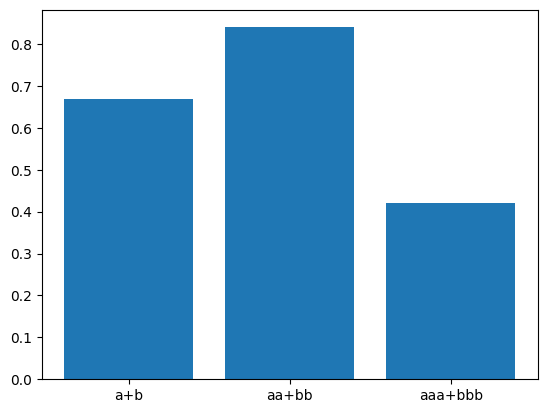

In [ ]:
NUM_SAMPLES = 100

def get_predictions(NUM_SAMPLES, x, y):
  i = 0
  accuracy = 0
  while i < NUM_SAMPLES:
    a, b = random.randint(x, y), random.randint(x, y)
    if a + b >= 1000:
      i += 1
      continue

    task = str(a) + '+' + str(b) + '='
    ans = a + b
    res = int(inference(task)[::-1])
    accuracy += int(ans == res)
    i += 1

  return accuracy / NUM_SAMPLES

import matplotlib.pyplot as plt

plt.bar(['a+b', 'aa+bb', 'aaa+bbb'], [get_predictions(NUM_SAMPLES, 0, 9), get_predictions(NUM_SAMPLES, 10, 99), get_predictions(NUM_SAMPLES, 100, 999)])

# Калькулятор

Датасет по тому же принципу, что и для сложения

In [ ]:
def add_padding(context, max_len, pad_token = '.'):
    return pad_token * (max_len - len(context)) + context

NUM_SAMPLES = 700000
context, target = [], []

def create_sample(x, y, operation):
  global context
  global target

  a, b = random.randint(x, y), random.randint(x, y)
  if a < b: # Чтобы не возникало отрицательных чисел при вычитании :)
    c = a
    a = b
    b = a

  task = str(a) + operation + str(b) + '='
  if operation == '+':
    ans = str(a + b)[::-1]
  if operation == '-':
    ans = str(a - b)[::-1]
  if operation == '*':
    ans = str(a * b)[::-1]
  if operation == '/':
    if b == 0:
      return
    ans = str(a // b)[::-1] # Деление будет целочисленное

  for i in range(len(ans)):
    context += [add_padding(task + ans[:i], 13)]
    target += [add_padding(task + ans[: i + 1], 13)]
  context += [add_padding(task + ans, 13)]
  target += [add_padding(task + ans + 'E', 13)]

for i in range(NUM_SAMPLES):
  create_sample(0, 9, '+')
  create_sample(0, 9, '-')
  create_sample(0, 9, '/')
  create_sample(0, 9, '*')
  create_sample(10, 99, '+')
  create_sample(10, 99, '-')
  create_sample(10, 99, '/')
  create_sample(10, 99, '*')

dataset = pd.DataFrame({'context': context, 'target': target}).drop_duplicates()
dataset

,context,target
0,.........6+2=,........6+2=8
1,........6+2=8,.......6+2=8E
2,.........9-9=,........9-9=0
3,........9-9=0,.......9-9=0E
4,.........9/9=,........9/9=1
...,...,...
1783558,.....54+19=37,....54+19=37E
1842792,.......80+68=,......80+68=8
1842793,......80+68=8,.....80+68=84
1842794,.....80+68=84,....80+68=841


In [ ]:
chars = ['.'] + [str(i) for i in range(0, 10)] + ['+', '-', '*', '/', '=', 'E']
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
stoi

{'.': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 '+': 11,
 '-': 12,
 '*': 13,
 '/': 14,
 '=': 15,
 'E': 16}

In [ ]:
dataset['context_encoded'] = dataset['context'].apply(lambda x: [stoi[i] for i in x])
dataset['target_encoded'] = dataset['target'].apply(lambda x: [stoi[i] for i in x])
dataset

,context,target,context_encoded,target_encoded
0,.........6+2=,........6+2=8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 3, 15]","[0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 3, 15, 9]"
1,........6+2=8,.......6+2=8E,"[0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 3, 15, 9]","[0, 0, 0, 0, 0, 0, 0, 7, 11, 3, 15, 9, 16]"
2,.........9-9=,........9-9=0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 12, 10, 15]","[0, 0, 0, 0, 0, 0, 0, 0, 10, 12, 10, 15, 1]"
3,........9-9=0,.......9-9=0E,"[0, 0, 0, 0, 0, 0, 0, 0, 10, 12, 10, 15, 1]","[0, 0, 0, 0, 0, 0, 0, 10, 12, 10, 15, 1, 16]"
4,.........9/9=,........9/9=1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 14, 10, 15]","[0, 0, 0, 0, 0, 0, 0, 0, 10, 14, 10, 15, 2]"
...,...,...,...,...
1783558,.....54+19=37,....54+19=37E,"[0, 0, 0, 0, 0, 6, 5, 11, 2, 10, 15, 4, 8]","[0, 0, 0, 0, 6, 5, 11, 2, 10, 15, 4, 8, 16]"
1842792,.......80+68=,......80+68=8,"[0, 0, 0, 0, 0, 0, 0, 9, 1, 11, 7, 9, 15]","[0, 0, 0, 0, 0, 0, 9, 1, 11, 7, 9, 15, 9]"
1842793,......80+68=8,.....80+68=84,"[0, 0, 0, 0, 0, 0, 9, 1, 11, 7, 9, 15, 9]","[0, 0, 0, 0, 0, 9, 1, 11, 7, 9, 15, 9, 5]"
1842794,.....80+68=84,....80+68=841,"[0, 0, 0, 0, 0, 9, 1, 11, 7, 9, 15, 9, 5]","[0, 0, 0, 0, 9, 1, 11, 7, 9, 15, 9, 5, 2]"


In [ ]:
train_dataset = TensorDataset(torch.tensor(np.stack(dataset['context_encoded'].values)[:int(len(dataset) * 0.8)]),
                              torch.tensor(np.stack(dataset['target_encoded'].values)[:int(len(dataset) * 0.8)]))

val_dataset = TensorDataset(torch.tensor(np.stack(dataset['context_encoded'].values)[int(len(dataset) * 0.8):]),
                            torch.tensor(np.stack(dataset['target_encoded'].values)[int(len(dataset) * 0.8):]))

In [ ]:
# hyperparameters
batch_size = 64
block_size = 13
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6 # D = 384 // 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

model = GPTLanguageModel().to(device)
m = model.to(device)

In [ ]:
try:
  optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

  for iter in range(max_iters):

      train_loss, val_loss = 0, 0
      batches = 0
      train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
      val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

      for context, target in train_loader:

          context, target = context.to(device), target.to(device)
          logits, _ = model(context)
          B, T, C = logits.shape
          logits = logits.view(B * T, C)

          mask = torch.zeros_like(target, dtype = torch.bool, device=device)
          for i in range(target.size(0)):
            index_eq = ((target[i] == 15).int()).nonzero(as_tuple=True)[0] # stoi['='] = 15
            mask[i, :index_eq + 1] = True
            masked_targets = target.masked_fill(mask, 0)
            masked_targets = masked_targets.view(B * T)

            loss = F.cross_entropy(logits, masked_targets, ignore_index = 0)

          train_loss += loss

          optimizer.zero_grad(set_to_none = True)
          loss.backward()
          optimizer.step()

          batches += 1
          if batches > 50:
            break

      for context, target in val_loader:
          context, target = context.to(device), target.to(device)
          with torch.no_grad():
              logits, _ = model(context)
              B, T, C = logits.shape

              logits = logits.view(B * T, C)

              mask = torch.zeros_like(target, dtype = torch.bool, device=device)
              for i in range(target.size(0)):
                index_eq = (target[i] == 15).nonzero(as_tuple=True)[0]
                mask[i, :index_eq + 1] = True
                masked_targets = target.masked_fill(mask, 0)
                masked_targets = masked_targets.view(B * T)

                loss = F.cross_entropy(logits, masked_targets, ignore_index = 0)

              val_loss += loss

          batches += 1
          if batches > 100:
            break

      if iter % 50 == 0:
        print(f'{iter}/{max_iters}. Train loss: {train_loss / 50} , Valid loss: {val_loss / 50}')
except KeyboardInterrupt: 0

0/5000. Train loss: 2.2532362937927246 , Valid loss: 2.0120201110839844
50/5000. Train loss: 1.3832560777664185 , Valid loss: 1.3684803247451782
100/5000. Train loss: 1.0406014919281006 , Valid loss: 1.0072081089019775
150/5000. Train loss: 0.6329367160797119 , Valid loss: 0.6519628763198853
200/5000. Train loss: 0.5978934168815613 , Valid loss: 0.5829275250434875
250/5000. Train loss: 0.5503133535385132 , Valid loss: 0.5501938462257385
300/5000. Train loss: 0.5367287993431091 , Valid loss: 0.536878228187561
350/5000. Train loss: 0.4794479012489319 , Valid loss: 0.5101238489151001
400/5000. Train loss: 0.433556467294693 , Valid loss: 0.4591020345687866
450/5000. Train loss: 0.39261892437934875 , Valid loss: 0.40951722860336304
500/5000. Train loss: 0.37071171402931213 , Valid loss: 0.3846268057823181
550/5000. Train loss: 0.3064945340156555 , Valid loss: 0.3440845310688019
600/5000. Train loss: 0.2610361874103546 , Valid loss: 0.30954113602638245
650/5000. Train loss: 0.237883105874061

## График accuracy для калькулятора

Точность для а+б возрасла более, чем на 0.1, в сравнении в результатами сложения. Точность аа+бб, наоборот, уменьшилась.

Во всех экспериментах модели было сложнее всего выучить умножение двузначных чисел аа*бб, что вполне логично, так как и для нас на бумаге этот вид примера окажется сложнее, чем остальные представленные.

В других экспериментах точность вычитания была чуть выше, но всё равно не доходила до сложения

<BarContainer object of 8 artists>

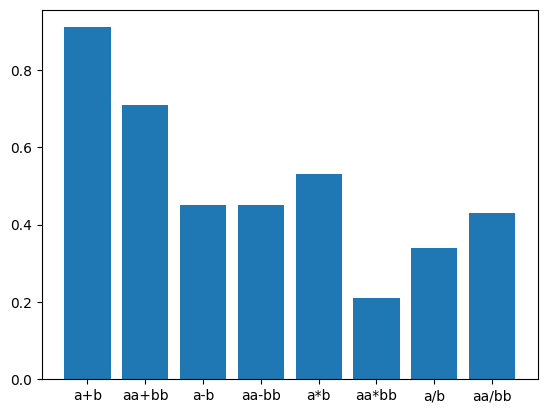

In [ ]:
NUM_SAMPLES = 100

def inference(sample):
  samle_str = '.' * (13 - len(sample)) + sample
  context = torch.tensor([encode(samle_str)], dtype = torch.int32)
  context = context.to(device)
  res = decode(m.generate(context, max_new_tokens = 17)[0].tolist()).replace('.', '')
  res = res[res.index('=') + 1 :res.index('E')]
  return res

def get_predictions(NUM_SAMPLES, x, y, operation):
  i = 0
  accuracy = 0
  while i < NUM_SAMPLES:
    a, b = random.randint(x, y), random.randint(x, y)

    task = str(a) + operation + str(b) + '='
    if operation == '+':
      ans = a + b
    if operation == '-':
      ans = a - b
    if operation == '*':
      ans = a * b
    if operation == '/':
      if b == 0:
        i += 1
        continue
      ans = a // b

    res = int(inference(task)[::-1])
    accuracy += int(ans == res)
    i += 1

  return accuracy / NUM_SAMPLES

plt.bar(['a+b', 'aa+bb', 'a-b', 'aa-bb', 'a*b', 'aa*bb', 'a/b', 'aa/bb'],
        [get_predictions(NUM_SAMPLES, 0, 9, '+'), get_predictions(NUM_SAMPLES, 10, 99, '+'),
         get_predictions(NUM_SAMPLES, 0, 9, '-'), get_predictions(NUM_SAMPLES, 10, 99, '-'),
         get_predictions(NUM_SAMPLES, 0, 9, '*'), get_predictions(NUM_SAMPLES, 10, 99, '*'),
         get_predictions(NUM_SAMPLES, 0, 9, '/'), get_predictions(NUM_SAMPLES, 10, 99, '/')],)